In [4]:
import numpy as np
import pandas as pd
import torch 
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
from sklearn.metrics import f1_score

### Data Preprocessing

In [2]:
data = pd.read_csv('data_bri_labelled.csv', sep='\t')

In [3]:
data.drop(columns = ['Unnamed: 0'], inplace=True)

In [4]:
for i in data['text'].head(100):
    print(i)

Info
saya mau tanya jadwal pembuatan kartu mahasiswa di BRI fontein kupang
....
Semalam saya tari tunai.tapi uang tidak keluar dari atm.tapi saldo rekening berkurang
Complain mbk?
pertanyaan umum
Briguna Karya
Ya
Oh ya
Apa yang harus saya bawa ke bank BRI terdekat jika saya sudah mengajukan transfer sesama BRI lewat eform bri
Penanganan uang yg setor tunai macet di atm emg lama ya min?
brimo
Sayah mau.pemgajuan.pijaman
Info
Kur bri
Dwek q ilang 100 ewu
Info
Brimo
Assalamu'alaikum
Selamat pagi
Mohon bantuannya Semalam 12:30 sy melakukan pembelian pulsa sebesar 50rb ke nomor 0819-9009-1553 tp sampai saat ini pulsa tidak masuk tetapi saldo sudah terpotong.
Pertanyaan umum
Individu
SYARAT PENDAFTARAN
Kalo mau ambil pinjaman untuk renovasi rumah bisa gak
33351598
Itu ada yg in box atasnama adminBRI
Halo kak maaf knp rekening saya klw d transferkan tidak bisa?? Sama tarik tunai di mesin ATM kartu chipnya tidak terbaca
Info lokasi kantor cabang
Mohon  bantuanya
Akun IB terblokir
Lupa pasword


In [207]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import string

def preprocessing_text(text):
    text = text.lower()
    list_text = re.findall(r'\w+', text)
    text = " ".join(list_text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("","",string.punctuation))
    text = text.strip()
    
    
    text = text.replace('\n', ' ')
    text = re.sub(' +', ' ', text)
    text = text.lstrip()
    
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    text = stopword.remove(text)
    
    #create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)
    
    return text

In [208]:
data['text'] = data['text'].apply(lambda text: preprocessing_text(text))

/home/jupyter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [210]:
data.dropna(inplace=True)

/home/jupyter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [212]:
data.to_csv(r'data_cleaned.csv', index=False)

### nodes

In [5]:
df = pd.read_csv('data_cleaned.csv') 

In [6]:
df.dropna(inplace=True) 

In [7]:
df

,text,label
0,info,1
1,saya mau tanya jadwal pembuatan kartu mahasisw...,0
2,semalam saya tari tunai tapi uang tidak keluar...,-1
3,complain mbk,-1
4,pertanyaan umum,-1
...,...,...
19305,sy mau pinjam dana kur dengan jaminan bpkb mot...,0
19306,saya stor tunai uangnya masuk tapi saldo tidak...,0
19307,saya isi pulsa xl dengan aplikasi brimo saldo ...,0
19308,tidak trima kasih,-1


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
# create CountVectorizer object
vectorizer = CountVectorizer()
corpus = df['text'].tolist()
# learn the vocabulary and store CountVectorizer sparse matrix in X
X = vectorizer.fit_transform(corpus)

In [9]:
len(vectorizer.get_feature_names())

9791

### create graph

In [10]:
def label_normalize(label):
    return label+1

In [11]:
%store -r source

In [12]:
len(source)

19310

In [13]:
df['label'] = df['label'].apply(lambda label: label_normalize(label))

In [14]:
# def create_graph(text, vectorizer, source, label, duration):
#     nodes = []
#     for i in text.split():
#         node = vectorizer.transform([i]).toarray()
#         #print("node",tf.convert_to_tensor(vectorizer.transform([i]).toarray()))
#         #print(node)
#         #print(len(node[0]))
#         #new_node = np.append(node[0], duration)
#         #print(len(new_node))
#         nodes.append(node)
#         #print(type(np.array(nodes)))
#         break
        
#     edges = torch.tensor([source[0], source[1]])
#     nodes = torch.FloatTensor(nodes)
#     graph = data.Data(x=nodes, edge_index=edges, y=[label])
#     return graph

In [15]:
def create_graph(text, vectorizer, source, label):
    nodes = []
    for i in text.split():
        node = vectorizer.transform([i]).toarray()
        #print("node",tf.convert_to_tensor(vectorizer.transform([i]).toarray()))
        #print(node)
        nodes.append(node[0])
        #print(type(np.array(nodes)))
        
    edges = torch.tensor([source[0], source[1]])
    nodes = torch.FloatTensor(nodes)
    #label = torch.FloatTensor(label)
    #print(source[2])
    edge_attribute = torch.FloatTensor(source[2])
    graph = data.Data(x=nodes, edge_index=edges, edge_weight=edge_attribute, y=[label])
    return graph

In [16]:
import torch_geometric.data as data
data_graph = []
for i,text in enumerate(df["text"]):
    print(i,end=" ")
    data_graph.append(create_graph(text, vectorizer, source[i], df.iloc[i]['label']))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

/home/jupyter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()


21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290

In [17]:
len(data_graph)*0.8

15448.0

In [18]:
torch.manual_seed(12345)

train_dataset = data_graph[:int(len(data_graph)*0.8)]
test_dataset = data_graph[int(len(data_graph)*0.8):]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 15448
Number of test graphs: 3862


### Mini-batching of graphs

Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.
In the image or language domain, this procedure is typically achieved by **rescaling** or **padding** each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension.
The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batch_size`.

However, for GNNs the two approaches described above are either not feasible or may result in a lot of unnecessary memory consumption.
Therefore, PyTorch Geometric opts for another approach to achieve parallelization across a number of examples. Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension:

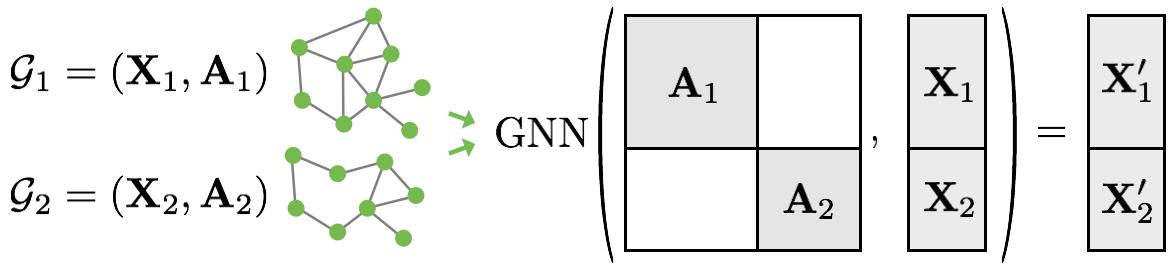

This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:

In [19]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 512
DataBatch(x=[4457, 9791], edge_index=[2, 4555], y=[512], edge_weight=[4555], batch=[4457], ptr=[513])

Step 2:
Number of graphs in the current batch: 512
DataBatch(x=[4074, 9791], edge_index=[2, 4180], y=[512], edge_weight=[4180], batch=[4074], ptr=[513])

Step 3:
Number of graphs in the current batch: 512
DataBatch(x=[3943, 9791], edge_index=[2, 4035], y=[512], edge_weight=[4035], batch=[3943], ptr=[513])

Step 4:
Number of graphs in the current batch: 512
DataBatch(x=[4190, 9791], edge_index=[2, 4288], y=[512], edge_weight=[4288], batch=[4190], ptr=[513])

Step 5:
Number of graphs in the current batch: 512
DataBatch(x=[4010, 9791], edge_index=[2, 4101], y=[512], edge_weight=[4101], batch=[4010], ptr=[513])

Step 6:
Number of graphs in the current batch: 512
DataBatch(x=[4373, 9791], edge_index=[2, 4472], y=[512], edge_weight=[4472], batch=[4373], ptr=[513])

Step 7:
Number of graphs in the current batch: 512
DataBatch(x=[4252, 9791],

### GCN

## Training a Graph Convolutional Network (GCN)

Training a GCN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GCNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [20]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        #self.edge_weight = torch.nn.Parameter(torch.ones(594))
        self.conv1 = GraphConv(9791, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        # self.lin = Linear(hidden_channels, 3)

    def forward(self, x, edge_index, batch, edge_weight):
        #print(self.edge_weight)
        # 1. Obtain node embeddings 
        #edge_weight = torch.nn.Parameter(edge_weight)
        #print(edge_weight)
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        # x = x.relu()
        # x = self.conv3(x, edge_index, edge_weight.sigmoid())

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        #x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GraphConv(9791, 64)
  (conv2): GraphConv(64, 64)
)


In [21]:
from sklearn.metrics import precision_recall_fscore_support
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         #print(type(data.x), type(data.edge_index), type(data.batch))
         #print(data.num_edges)
         print((data.x.shape), (data.edge_index.shape), (data.batch.shape), (data.edge_weight.shape))
         print(data.num_edges)
         out = model(data.x, data.edge_index, data.batch, data.edge_weight)  # Perform a single forward pass.
         new_y = []
         for i in data.y:
             new_y.append(i[0])
         new_y = torch.Tensor(new_y).long()
         loss = criterion(out, new_y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch, data.edge_weight)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         new_y = []
         for i in data.y:
             new_y.append(i[0])
         new_y = torch.Tensor(new_y).long()
         correct += int((pred == new_y).sum())  # Check against ground-truth labels.
            
     # print(pred)
     # print(new_y)
     f1score = f1_score(new_y, pred, average='weighted')
     #f1score = precision_recall_fscore_support(new_y, pred, average='weighted')
     return correct / len(loader.dataset), f1score  # Derive ratio of correct predictions.


In [22]:
hidden_param = [20,40,60,80,100]
lr_param = [0.1, 0.001, 0.0001, 0.00001]

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        #self.edge_weight = torch.nn.Parameter(torch.ones(594))
        self.conv1 = GraphConv(9791, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        # self.lin = Linear(hidden_channels, 3)

    def forward(self, x, edge_index, batch):
        #print(self.edge_weight)
        # 1. Obtain node embeddings 
        #edge_weight = torch.nn.Parameter(edge_weight)
        #print(edge_weight)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv3(x, edge_index, edge_weight.sigmoid())

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        #x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GraphConv(9791, 64)
  (conv2): GraphConv(64, 64)
)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         #print(type(data.x), type(data.edge_index), type(data.batch))
         #print(data.num_edges)
         #print((data.x.shape), (data.edge_index.shape), (data.batch.shape))
         #print(data.num_edges)
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         new_y = []
         for i in data.y:
             new_y.append(i[0])
         new_y = torch.Tensor(new_y).long()
         loss = criterion(out, new_y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         new_y = []
         for i in data.y:
             new_y.append(i[0])
         new_y = torch.Tensor(new_y).long()
         correct += int((pred == new_y).sum())  # Check against ground-truth labels.
            
     # print(pred)
     # print(new_y)
     f1score = f1_score(new_y, pred, average='weighted')
     #f1score = precision_recall_fscore_support(new_y, pred, average='weighted')
     return correct / len(loader.dataset), f1score  # Derive ratio of correct predictions.


In [41]:
for i in hidden_param:
    for j in lr_param:
        print("Parameter",i,j)
        model = GCN(hidden_channels=i)
        optimizer = torch.optim.Adam(model.parameters(), lr=j)
        criterion = torch.nn.CrossEntropyLoss()
        
        for epoch in range(1, 101):
            train()
            train_acc, f1score_train = test(train_loader)
            test_acc, f1score_test = test(test_loader)
            print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f} , F1-score: {f1score_test:.4f}')

Parameter 20 0.1
Epoch: 001, Train Acc: 0.6991, Test Acc: 0.6956 , F1-score: 0.4848
Epoch: 002, Train Acc: 0.7193, Test Acc: 0.7122 , F1-score: 0.5558
Epoch: 003, Train Acc: 0.7234, Test Acc: 0.7136 , F1-score: 0.5828
Epoch: 004, Train Acc: 0.7231, Test Acc: 0.7128 , F1-score: 0.5734
Epoch: 005, Train Acc: 0.7269, Test Acc: 0.7075 , F1-score: 0.5875
Epoch: 006, Train Acc: 0.7262, Test Acc: 0.7043 , F1-score: 0.5556
Epoch: 007, Train Acc: 0.7247, Test Acc: 0.7062 , F1-score: 0.5574
Epoch: 008, Train Acc: 0.7306, Test Acc: 0.7086 , F1-score: 0.5452
Epoch: 009, Train Acc: 0.7314, Test Acc: 0.7078 , F1-score: 0.5326
Epoch: 010, Train Acc: 0.7413, Test Acc: 0.7080 , F1-score: 0.5882
Epoch: 011, Train Acc: 0.7330, Test Acc: 0.7101 , F1-score: 0.5582
Epoch: 012, Train Acc: 0.7318, Test Acc: 0.7020 , F1-score: 0.5239
Epoch: 013, Train Acc: 0.7375, Test Acc: 0.6964 , F1-score: 0.5234
Epoch: 014, Train Acc: 0.7453, Test Acc: 0.7115 , F1-score: 0.5916
Epoch: 015, Train Acc: 0.7482, Test Acc: 0.71

## Chebynev GCN

In [42]:
from torch_geometric.nn import ChebConv

class Chebynev(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Chebynev, self).__init__()
        torch.manual_seed(12345)
        #self.edge_weight = torch.nn.Parameter(torch.ones(594))
        self.conv1 = ChebConv(1000, hidden_channels,2)
        self.conv2 = ChebConv(hidden_channels, hidden_channels,2)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #self.lin = Linear(hidden_channels, 3)

    def forward(self, x, edge_index, batch, edge_weight):
        #print(self.edge_weight)
        # 1. Obtain node embeddings 
        #edge_weight = torch.nn.Parameter(edge_weight)
        #print(edge_weight)
        x = self.conv1(x, edge_index, edge_weight.sigmoid())
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight.sigmoid())
        #x = x.relu()
        #x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        #x = self.lin(x)
        
        return x

In [43]:
hidden_param = [20,40,60,80,100]
lr_param = [0.1, 0.001, 0.0001, 0.00001]

In [44]:
for i in hidden_param:
    for j in lr_param:
        print("Parameter",i,j)
        model = Chebynev(hidden_channels=i)
        optimizer = torch.optim.Adam(model.parameters(), lr=j)
        criterion = torch.nn.CrossEntropyLoss()
        
        for epoch in range(1, 101):
            train()
            train_acc, f1score_train = test(train_loader)
            test_acc, f1score_test = test(test_loader)
            print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f} , F1-score: {f1score_test:.4f}')

Parameter 20 0.1
Epoch: 001, Train Acc: 0.7361, Test Acc: 0.7210 , F1-score: 0.5342
Epoch: 002, Train Acc: 0.7474, Test Acc: 0.7196 , F1-score: 0.5590
Epoch: 003, Train Acc: 0.7650, Test Acc: 0.7178 , F1-score: 0.5871
Epoch: 004, Train Acc: 0.7691, Test Acc: 0.7027 , F1-score: 0.5587
Epoch: 005, Train Acc: 0.7759, Test Acc: 0.7096 , F1-score: 0.5742
Epoch: 006, Train Acc: 0.7803, Test Acc: 0.7064 , F1-score: 0.5547
Epoch: 007, Train Acc: 0.7834, Test Acc: 0.7080 , F1-score: 0.5730
Epoch: 008, Train Acc: 0.7842, Test Acc: 0.7194 , F1-score: 0.5777
Epoch: 009, Train Acc: 0.7847, Test Acc: 0.7170 , F1-score: 0.5757
Epoch: 010, Train Acc: 0.7925, Test Acc: 0.7162 , F1-score: 0.6077
Epoch: 011, Train Acc: 0.8005, Test Acc: 0.7115 , F1-score: 0.5889
Epoch: 012, Train Acc: 0.7962, Test Acc: 0.7062 , F1-score: 0.6185
Epoch: 013, Train Acc: 0.7902, Test Acc: 0.7170 , F1-score: 0.5988
Epoch: 014, Train Acc: 0.8051, Test Acc: 0.6967 , F1-score: 0.5843
Epoch: 015, Train Acc: 0.7995, Test Acc: 0.70

### Transformer Graph

In [60]:
def create_graph(text, vectorizer, source, label):
    nodes = []
    for i in text.split():
        node = vectorizer.transform([i]).toarray()
        #print("node",tf.convert_to_tensor(vectorizer.transform([i]).toarray()))
        #print(node)
        nodes.append(node[0])
        #print(type(np.array(nodes)))
        
    edges = torch.tensor([source[0], source[1]])
    nodes = torch.FloatTensor(nodes)
    #label = torch.FloatTensor(label)
    #print(source[2])
    edge_attribute = torch.FloatTensor(source[2])
    graph = data.Data(x=nodes, edge_index=edges, edge_attr=edge_attribute, y=[label])
    return graph

In [61]:
import torch_geometric.data as data
data_graph_attr = []
for i,text in enumerate(df["text"]):
    print(i,end=" ")
    data_graph_attr.append(create_graph_with_attr(text, vectorizer, source[i], df.iloc[i]['label']))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [62]:
torch.manual_seed(12345)

train_dataset_attr = data_graph_attr[:int(len(data_graph_attr)*0.8)]
test_dataset_attr = data_graph_attr[int(len(data_graph_attr)*0.8):]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 3776
Number of test graphs: 944


In [63]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset_attr, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset_attr, batch_size=128, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 128
DataBatch(x=[590, 3535], edge_index=[2, 590], edge_attr=[590], y=[128], batch=[590], ptr=[129])

Step 2:
Number of graphs in the current batch: 128
DataBatch(x=[560, 3535], edge_index=[2, 560], edge_attr=[560], y=[128], batch=[560], ptr=[129])

Step 3:
Number of graphs in the current batch: 128
DataBatch(x=[684, 3535], edge_index=[2, 684], edge_attr=[684], y=[128], batch=[684], ptr=[129])

Step 4:
Number of graphs in the current batch: 128
DataBatch(x=[713, 3535], edge_index=[2, 713], edge_attr=[713], y=[128], batch=[713], ptr=[129])

Step 5:
Number of graphs in the current batch: 128
DataBatch(x=[537, 3535], edge_index=[2, 537], edge_attr=[537], y=[128], batch=[537], ptr=[129])

Step 6:
Number of graphs in the current batch: 128
DataBatch(x=[544, 3535], edge_index=[2, 544], edge_attr=[544], y=[128], batch=[544], ptr=[129])

Step 7:
Number of graphs in the current batch: 128
DataBatch(x=[532, 3535], edge_index=[2, 532], edge_attr=[532]

In [89]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import global_mean_pool


class TransformerGraph(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(TransformerGraph, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = TransformerConv(3535, hidden_channels, edge_dim=1)
        self.conv2 = TransformerConv(hidden_channels, hidden_channels, edge_dim=1)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #self.lin = Linear(hidden_channels, 3)

    def forward(self, x, edge_index, batch, edge_attr):
        # 1. Obtain node embeddings 
        #x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr.sigmoid())
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr.sigmoid())
        #x = x.relu()
        #x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        #x = self.lin(x)
        
        return x

model = GAT(hidden_channels=64) 
print(model)

GAT(
  (conv1): TransformerConv(3700, 64, heads=1)
  (conv2): TransformerConv(64, 64, heads=1)
)


In [92]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         #print(type(data.x), type(data.edge_index), type(data.batch))
         #print(data.num_edges)
         #print((data.x.shape), (data.edge_index.shape), (data.batch.shape))
         #print(data.num_edges)
         print(data.edge_index)
         out = model(data.x, data.edge_index, data.batch, data.edge_attr)  # Perform a single forward pass.
         
         new_y = []
         for i in data.y:
             new_y.append(i[0])
         new_y = torch.Tensor(new_y).long()
         loss = criterion(out, new_y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch, data.edge_weight)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         new_y = []
         for i in data.y:
             new_y.append(i[0])
         new_y = torch.Tensor(new_y).long()
         correct += int((pred == new_y).sum())  # Check against ground-truth labels.
            
     # print(pred)
     # print(new_y)
     f1score = f1_score(new_y, pred, average='weighted')
     return correct / len(loader.dataset), f1score  # Derive ratio of correct predictions.


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [94]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = TransformerGraph(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 21):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

tensor([[  0,   0,   1,  ..., 575, 581, 581],
        [  0,   1,   2,  ..., 581, 582, 583]])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x584 and 1x64)